In [15]:
from __future__ import annotations

import dataclasses
import json
import pathlib
import threading
import time

import cv2
import h5py
import hdf5plugin
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import tqdm
from rpg_e2vid.utils.loading_utils import load_model
from rpg_e2vid.utils.inference_utils import events_to_voxel_grid

import const
import utils

In [2]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [3]:
def read_events_h5(path: pathlib.Path) -> tuple[np.ndarray, np.ndarray]:
    with h5py.File(path, "r") as f:
        offset = f["t_offset"][()]
        x = f["events"]["x"][()].astype(np.int32)
        y = f["events"]["y"][()].astype(np.int32)
        ts = (f["events"]["t"][()].astype(np.int64) + offset) // 1_000
        pol = f["events"]["p"][()].astype(np.int32)
        events = np.array([ts, x, y, pol]).T
        ms_to_idx = f["ms_to_idx"][()].astype(np.int32)
        return events, ms_to_idx

In [22]:
#model = utils.load_model_2(pathlib.Path("../pretrained/better_e2vid_weights_v5.pth"))
model = load_model(pathlib.Path("../pretrained/E2VID_lightweight.pth.tar"))
model = model.to(const.DEVICE)

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [17]:
SEQUENCE = "zurich_city_00_b"

In [18]:
events, ms_to_idx = read_events_h5(
    pathlib.Path(f"../data/raw/dsec/{SEQUENCE}/events.h5")
)
_, ts_counts = np.unique(events[:, 0], return_counts=True)
width = events[:, 1].max() + 1
height = events[:, 2].max() + 1

In [19]:
ts_path = pathlib.Path(f"../data/raw/dsec/{SEQUENCE}/timestamps.txt")
img_paths = list(pathlib.Path(f"../data/raw/dsec/{SEQUENCE}/imgs/").glob("*.png"))
calib_path = pathlib.Path(f"../data/raw/dsec/{SEQUENCE}/cam_to_cam.yaml")
src_frames = utils.Frames.from_paths(img_paths, ts_path, calib_path)

Reading images: 100%|██████████| 1463/1463 [00:31<00:00, 45.98it/s]


In [20]:
def read_rect_map(rectify_path: pathlib.Path) -> np.ndarray:
    with h5py.File(rectify_path, "r") as f:
        return f["rectify_map"][:]  # type: ignore

In [21]:
rect_map = read_rect_map(pathlib.Path(f"../data/raw/dsec/{SEQUENCE}/rectify_map.h5"))

In [10]:
window_ts_start = 0
ts_offset = 0
idx_offset = 0
freq = (src_frames.timestamps[1:] - src_frames.timestamps[:-1]).mean() / 1_000
freq = int(round(freq))
ev_freq = freq // 2
pbar = tqdm.tqdm(range(1, len(ms_to_idx[:10000]), ev_freq), desc="Overlaying frames")

out = cv2.VideoWriter(
    "overlay.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    30,
    (rect_map.shape[1], rect_map.shape[0]),
)
for i in pbar:
    from_idx = ms_to_idx[i - ev_freq]
    to_idx = ms_to_idx[i]
    window = events[from_idx:to_idx].copy()
    window[:, [1, 2]] = rect_map[window[:, 2], window[:, 1]]
    window = window[
        (window[:, 1] >= 0)
        & (window[:, 1] < rect_map.shape[1])
        & (window[:, 2] >= 0)
        & (window[:, 2] < rect_map.shape[0])
    ]

    window = window.astype(np.float32)
    if not len(window):
        continue

    frame_idx = i // freq
    frame = src_frames.array[frame_idx].copy()

    pos_window = window[window[:, 3] == 1]
    neg_window = window[window[:, 3] == 0]

    frame[pos_window[:, 2].astype(int), pos_window[:, 1].astype(int)] = [0, 0, 255]
    frame[neg_window[:, 2].astype(int), neg_window[:, 1].astype(int)] = [255, 0, 0]

    out.write(frame)

out.release()

Overlaying frames: 100%|██████████| 400/400 [00:12<00:00, 32.65it/s]


In [25]:
w_len = 50
empty_frame = np.ones((height, width), dtype=np.uint8) * 128
model.eval()
out = cv2.VideoWriter(
    "rec-eval.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 30, (width, height), isColor=False
)
prev = None
n_empty_frames = ts_offset // w_len
for _ in range(n_empty_frames):
    out.write(empty_frame)
eit = utils.EventWindowIterator(events, ts_counts, w_len, w_len, ts_offset)
for window in tqdm.tqdm(eit, desc=f"Offset {ts_offset}"):
    window = window.astype(np.float32)
    voxel_grid = events_to_voxel_grid(window, 5, width, height)
    voxel_grid = torch.from_numpy(voxel_grid).to(const.DEVICE).unsqueeze(0).float()

    with torch.no_grad():
        # pred = model(voxel_grid)["image"]
        pred, prev = model(voxel_grid, prev)
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
        out.write(pred)
out.release()
#model.reset_states()

Offset 0: 100%|██████████| 1463/1463 [02:42<00:00,  8.98it/s]


In [ ]:
all_videos = []
for video in pathlib.Path("videos/test/").glob("*.mp4"):
    print(video)
    cap = cv2.VideoCapture(str(video))
    video_frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        video_frames.append(frame)
    cap.release()
    all_videos.append(video_frames)
min_len = min(len(video) for video in all_videos)
all_videos = [video[:min_len] for video in all_videos]
all_videos = np.array(all_videos)

videos\test\0-offset-interlaken_00_f.mp4
videos\test\100-offset-interlaken_00_f.mp4
videos\test\200-offset-interlaken_00_f.mp4
videos\test\300-offset-interlaken_00_f.mp4
videos\test\400-offset-interlaken_00_f.mp4
videos\test\500-offset-interlaken_00_f.mp4
videos\test\600-offset-interlaken_00_f.mp4
videos\test\700-offset-interlaken_00_f.mp4


In [ ]:
V, N, H, W = all_videos.shape

top_vids = all_videos[: V // 2]
bot_vids = all_videos[V // 2 :]
top_vids_rows = np.concatenate(top_vids, axis=2)
bot_vids_rows = np.concatenate(bot_vids, axis=2)
all_vids = np.concatenate([top_vids_rows, bot_vids_rows], axis=1)
all_vids.shape
# bot_vids_rows = np.concatenate(bot_vids, axis=1)
# all_vids = np.concatenate([top_vids_rows, bot_vids_rows], axis=0)
# all_vids.shape


out = cv2.VideoWriter(
    f"videos/test/{SEQUENCE}-all.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    30,
    (all_vids.shape[2], all_vids.shape[1]),
    isColor=False,
)

for i, frame in enumerate(all_vids):
    cv2.putText(frame, f"Frame {i}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

    out.write(frame)

out.release()

In [ ]:
w_sizes = []
eit = utils.EventWindowIterator(events, ts_counts, w_len, w_len, ts_offset)
for window in tqdm.tqdm(eit):
    w_sizes.append(window.shape[0])

 99%|█████████▉| 1463/1477 [00:00<00:00, 214667.37it/s]


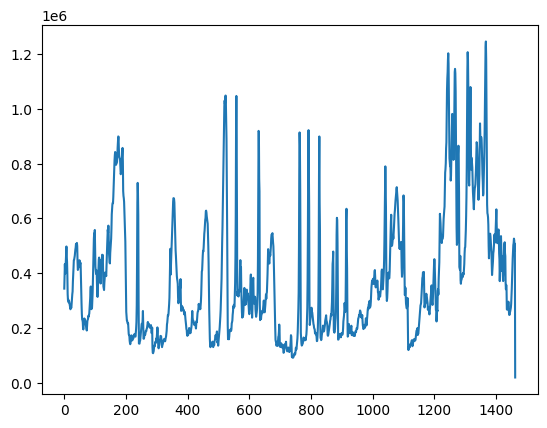

In [ ]:
plt.plot(w_sizes)

In [ ]:
med_event = int(np.median(w_sizes))
med_event

304462

In [ ]:
file = f"videos/test/{SEQUENCE}-median-events_count.mp4"
out = cv2.VideoWriter(
    file, cv2.VideoWriter_fourcc(*"mp4v"), 30, (width, height), isColor=False
)
n_empty_frames = ts_offset // w_len
for _ in range(n_empty_frames):
    out.write(empty_frame)
eit = utils.EventWindowIterator(events, ts_counts, w_len, w_len, ts_offset)
for window in tqdm.tqdm(eit):
    window = window.astype(np.float32)
    if window.shape[0] > med_event:
        indices = np.arange(window.shape[0])
        np.random.shuffle(indices)
        selected_indices = indices[:med_event]
        selected_indices = np.sort(selected_indices)
        window = window[selected_indices]
    voxel_grid = events_to_voxel_grid(window, 5, width, height)
    voxel_grid = torch.from_numpy(voxel_grid).to(const.DEVICE).unsqueeze(0).float()

    with torch.no_grad():
        pred = model(voxel_grid)["image"]
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
        out.write(pred)
out.release()
model.reset_states()

 99%|█████████▉| 1463/1477 [02:43<00:01,  8.95it/s]
